# 🔗 Intelligent Supply Chain Optimization System
## Notebook 03 — Feature Engineering

**Project:** Intelligent Supply Chain Optimization System  
**Phase:** Feature Engineering & Preprocessing  
**Input:** `supply_chain_eda_ready.csv` (output from Notebook 02)  
**Objective:** Transform raw data into a rich feature set ready for both LSTM and XGBoost models.

---

### 📋 What This Notebook Does
1. Load EDA-ready dataset
2. Time-based features (calendar, cyclic encoding)
3. Lag features (past demand signals)
4. Rolling window features (moving statistics)
5. Interaction features (promotion × price, etc.)
6. Supplier & inventory derived features
7. Encode categorical columns
8. Handle stockout-adjusted demand
9. Feature importance preview
10. Prepare & save two outputs:
    - `features_xgboost.csv` → flat feature matrix for XGBoost
    - `features_lstm.csv`    → sequential data for LSTM

---

## 📦 Section 1: Imports & Load Data

In [1]:
# ─────────────────────────────────────────────────────────────
# SECTION 1: IMPORTS & LOAD
# ─────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.rcParams['figure.figsize']    = (14, 5)
plt.rcParams['axes.spines.top']   = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titleweight']  = 'bold'
sns.set_palette('muted')

# ── Load ──
df = pd.read_csv('supply_chain_eda_ready.csv', parse_dates=['Date'])
df = df.sort_values(['SKU_ID', 'Warehouse_ID', 'Date']).reset_index(drop=True)

print(f'✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')
print(f'   Date range  : {df["Date"].min().date()} → {df["Date"].max().date()}')
print(f'   Columns     : {list(df.columns)}')

✅ Dataset loaded: 91,250 rows × 19 columns
   Date range  : 2024-01-01 → 2024-12-30
   Columns     : ['Date', 'SKU_ID', 'Warehouse_ID', 'Supplier_ID', 'Region', 'Units_Sold', 'Inventory_Level', 'Supplier_Lead_Time_Days', 'Reorder_Point', 'Order_Quantity', 'Unit_Cost', 'Unit_Price', 'Promotion_Flag', 'Stockout_Flag', 'Demand_Forecast', 'Month', 'DayOfWeek', 'Quarter', 'Week']


---
## 📅 Section 2: Time-Based Features

In [2]:
# ─────────────────────────────────────────────────────────────
# SECTION 2: TIME-BASED FEATURES
# ─────────────────────────────────────────────────────────────
# Why: LSTM will learn from raw sequences, but XGBoost needs
# explicit time features. Cyclic encoding prevents the model
# from treating Dec→Jan as a huge jump.
# ─────────────────────────────────────────────────────────────

# ── Basic calendar features ──
df['Year']         = df['Date'].dt.year
df['Month']        = df['Date'].dt.month
df['Day']          = df['Date'].dt.day
df['DayOfWeek']    = df['Date'].dt.dayofweek        # 0=Mon, 6=Sun
df['DayOfYear']    = df['Date'].dt.dayofyear
df['WeekOfYear']   = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter']      = df['Date'].dt.quarter
df['Is_Weekend']   = (df['DayOfWeek'] >= 5).astype(int)
df['Is_MonthEnd']  = df['Date'].dt.is_month_end.astype(int)
df['Is_MonthStart']= df['Date'].dt.is_month_start.astype(int)
df['Is_QuarterEnd']= df['Date'].dt.is_quarter_end.astype(int)

# ── Cyclic encoding (sin/cos) ──
# Captures the circular nature of time: Jan and Dec are adjacent
df['Month_sin']      = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos']      = np.cos(2 * np.pi * df['Month'] / 12)
df['DayOfWeek_sin']  = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos']  = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfYear_sin']  = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['DayOfYear_cos']  = np.cos(2 * np.pi * df['DayOfYear'] / 365)
df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)

time_features = ['Year','Month','Day','DayOfWeek','DayOfYear','WeekOfYear',
                 'Quarter','Is_Weekend','Is_MonthEnd','Is_MonthStart','Is_QuarterEnd',
                 'Month_sin','Month_cos','DayOfWeek_sin','DayOfWeek_cos',
                 'DayOfYear_sin','DayOfYear_cos','WeekOfYear_sin','WeekOfYear_cos']

print(f'✅ Time-based features created: {len(time_features)}')
print(f'   Features: {time_features}')
print(f'\n   Current shape: {df.shape}')

✅ Time-based features created: 19
   Features: ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'Is_Weekend', 'Is_MonthEnd', 'Is_MonthStart', 'Is_QuarterEnd', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'WeekOfYear_sin', 'WeekOfYear_cos']

   Current shape: (91250, 35)


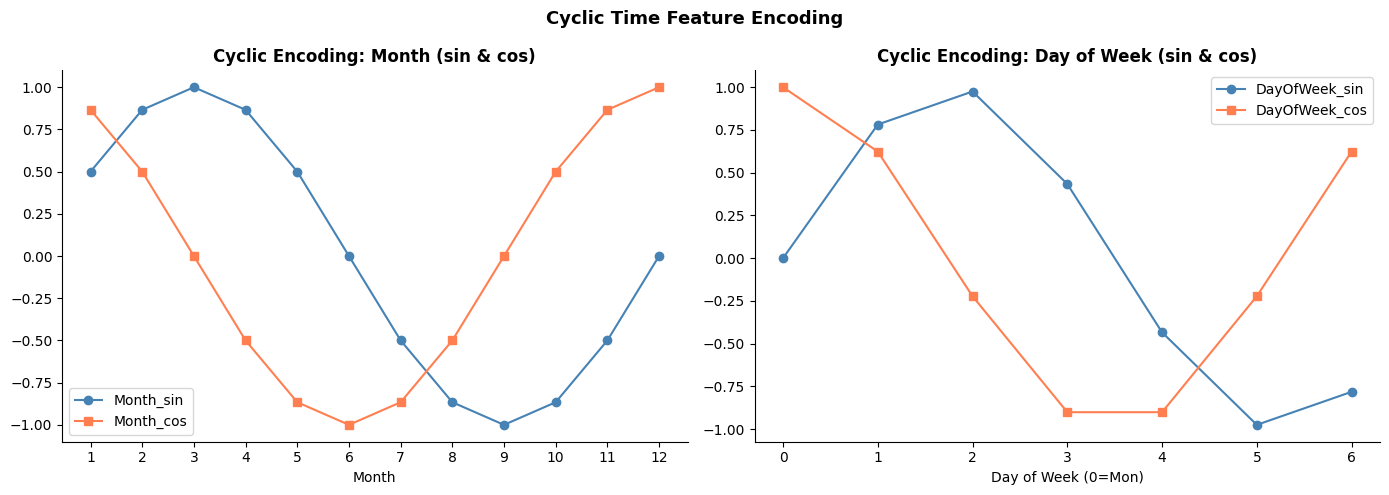

In [3]:
# Visualize cyclic encoding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Month cyclic
month_sample = df[['Month','Month_sin','Month_cos']].drop_duplicates().sort_values('Month')
axes[0].plot(month_sample['Month'], month_sample['Month_sin'],
             marker='o', label='Month_sin', color='steelblue')
axes[0].plot(month_sample['Month'], month_sample['Month_cos'],
             marker='s', label='Month_cos', color='coral')
axes[0].set_title('Cyclic Encoding: Month (sin & cos)')
axes[0].set_xlabel('Month')
axes[0].set_xticks(range(1,13))
axes[0].legend()

# DayOfWeek cyclic
dow_sample = df[['DayOfWeek','DayOfWeek_sin','DayOfWeek_cos']].drop_duplicates().sort_values('DayOfWeek')
axes[1].plot(dow_sample['DayOfWeek'], dow_sample['DayOfWeek_sin'],
             marker='o', label='DayOfWeek_sin', color='steelblue')
axes[1].plot(dow_sample['DayOfWeek'], dow_sample['DayOfWeek_cos'],
             marker='s', label='DayOfWeek_cos', color='coral')
axes[1].set_title('Cyclic Encoding: Day of Week (sin & cos)')
axes[1].set_xlabel('Day of Week (0=Mon)')
axes[1].set_xticks(range(7))
axes[1].legend()

plt.suptitle('Cyclic Time Feature Encoding', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## ⏳ Section 3: Lag Features

In [4]:
# ─────────────────────────────────────────────────────────────
# SECTION 3: LAG FEATURES
# ─────────────────────────────────────────────────────────────
# Why: Past demand is the strongest predictor of future demand.
# We create lags per (SKU_ID, Warehouse_ID) group so values
# don't bleed across different SKU/Warehouse combinations.
# ─────────────────────────────────────────────────────────────

GROUP_KEYS = ['SKU_ID', 'Warehouse_ID']

# Lag periods in days
LAG_PERIODS = [1, 2, 3, 7, 14, 21, 28, 30]

for lag in LAG_PERIODS:
    col_name = f'Units_Sold_Lag_{lag}'
    df[col_name] = df.groupby(GROUP_KEYS)['Units_Sold'].shift(lag)

# Lag for Inventory_Level (useful for stock momentum)
for lag in [1, 7]:
    df[f'Inventory_Lag_{lag}'] = df.groupby(GROUP_KEYS)['Inventory_Level'].shift(lag)

# Lag for Promotion_Flag (was there a promo recently?)
for lag in [1, 3, 7]:
    df[f'Promo_Lag_{lag}'] = df.groupby(GROUP_KEYS)['Promotion_Flag'].shift(lag)

lag_features = ([f'Units_Sold_Lag_{l}' for l in LAG_PERIODS] +
                [f'Inventory_Lag_{l}' for l in [1,7]] +
                [f'Promo_Lag_{l}' for l in [1,3,7]])

print(f'✅ Lag features created: {len(lag_features)}')
print(f'   Features: {lag_features}')
print(f'\n   NaN rows introduced (expected for early dates): {df[lag_features].isnull().any(axis=1).sum():,}')

✅ Lag features created: 13
   Features: ['Units_Sold_Lag_1', 'Units_Sold_Lag_2', 'Units_Sold_Lag_3', 'Units_Sold_Lag_7', 'Units_Sold_Lag_14', 'Units_Sold_Lag_21', 'Units_Sold_Lag_28', 'Units_Sold_Lag_30', 'Inventory_Lag_1', 'Inventory_Lag_7', 'Promo_Lag_1', 'Promo_Lag_3', 'Promo_Lag_7']

   NaN rows introduced (expected for early dates): 7,500


---
## 📊 Section 4: Rolling Window Features

In [5]:
# ─────────────────────────────────────────────────────────────
# SECTION 4: ROLLING WINDOW FEATURES
# ─────────────────────────────────────────────────────────────
# Why: Moving averages and std capture short-term trends
# and demand volatility — both critical for inventory decisions.
# We use shift(1) inside rolling to avoid data leakage.
# ─────────────────────────────────────────────────────────────

WINDOWS = [7, 14, 30]

for w in WINDOWS:
    # Rolling mean of past sales (shift 1 to avoid leakage)
    df[f'Rolling_Mean_{w}d'] = (
        df.groupby(GROUP_KEYS)['Units_Sold']
          .transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
    )
    # Rolling std — demand volatility
    df[f'Rolling_Std_{w}d'] = (
        df.groupby(GROUP_KEYS)['Units_Sold']
          .transform(lambda x: x.shift(1).rolling(w, min_periods=2).std())
    )
    # Rolling max
    df[f'Rolling_Max_{w}d'] = (
        df.groupby(GROUP_KEYS)['Units_Sold']
          .transform(lambda x: x.shift(1).rolling(w, min_periods=1).max())
    )
    # Rolling min
    df[f'Rolling_Min_{w}d'] = (
        df.groupby(GROUP_KEYS)['Units_Sold']
          .transform(lambda x: x.shift(1).rolling(w, min_periods=1).min())
    )

# Exponential Weighted Moving Average — gives more weight to recent data
for span in [7, 14]:
    df[f'EWMA_{span}d'] = (
        df.groupby(GROUP_KEYS)['Units_Sold']
          .transform(lambda x: x.shift(1).ewm(span=span, adjust=False).mean())
    )

# Demand momentum: ratio of recent 7d avg vs 30d avg
df['Demand_Momentum'] = df['Rolling_Mean_7d'] / (df['Rolling_Mean_30d'] + 1e-6)

rolling_features = (
    [f'Rolling_Mean_{w}d' for w in WINDOWS] +
    [f'Rolling_Std_{w}d'  for w in WINDOWS] +
    [f'Rolling_Max_{w}d'  for w in WINDOWS] +
    [f'Rolling_Min_{w}d'  for w in WINDOWS] +
    [f'EWMA_{s}d' for s in [7, 14]] +
    ['Demand_Momentum']
)

print(f'✅ Rolling window features created: {len(rolling_features)}')
print(f'   Features: {rolling_features}')

✅ Rolling window features created: 15
   Features: ['Rolling_Mean_7d', 'Rolling_Mean_14d', 'Rolling_Mean_30d', 'Rolling_Std_7d', 'Rolling_Std_14d', 'Rolling_Std_30d', 'Rolling_Max_7d', 'Rolling_Max_14d', 'Rolling_Max_30d', 'Rolling_Min_7d', 'Rolling_Min_14d', 'Rolling_Min_30d', 'EWMA_7d', 'EWMA_14d', 'Demand_Momentum']


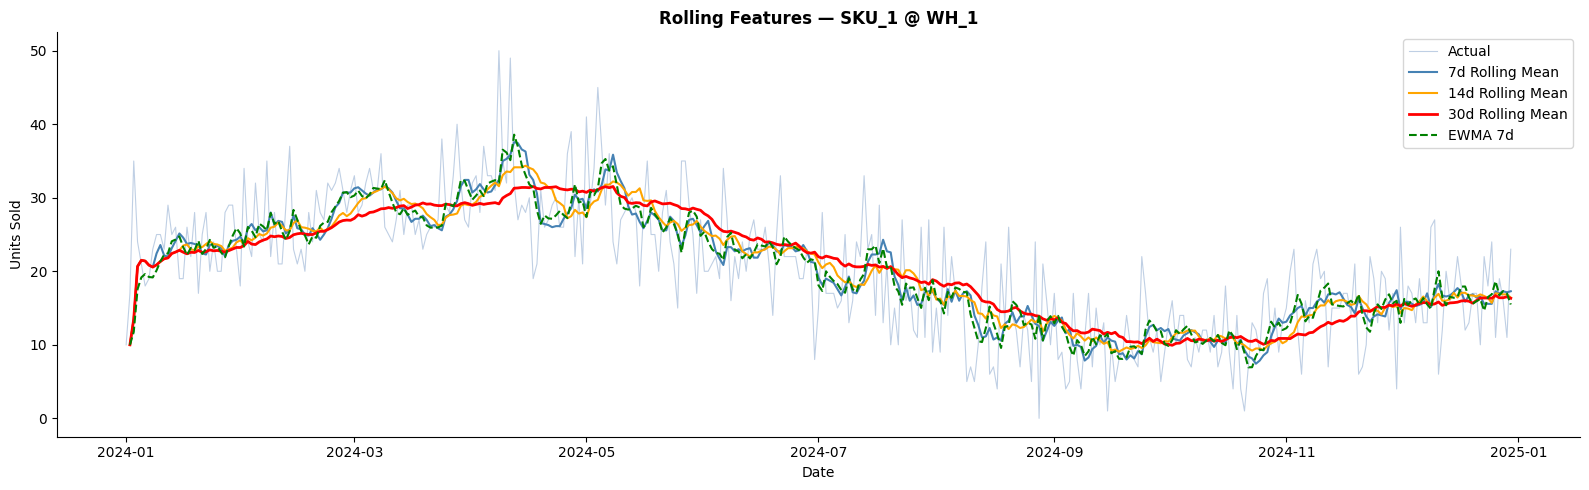

In [6]:
# Visualize rolling features for one SKU+Warehouse combo
sample_sku = df['SKU_ID'].value_counts().idxmax()
sample_wh  = df[df['SKU_ID']==sample_sku]['Warehouse_ID'].value_counts().idxmax()
sample_df  = df[(df['SKU_ID']==sample_sku) & (df['Warehouse_ID']==sample_wh)].copy()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sample_df['Date'], sample_df['Units_Sold'],
        color='lightsteelblue', linewidth=0.8, label='Actual', alpha=0.8)
ax.plot(sample_df['Date'], sample_df['Rolling_Mean_7d'],
        color='steelblue', linewidth=1.5, label='7d Rolling Mean')
ax.plot(sample_df['Date'], sample_df['Rolling_Mean_14d'],
        color='orange', linewidth=1.5, label='14d Rolling Mean')
ax.plot(sample_df['Date'], sample_df['Rolling_Mean_30d'],
        color='red', linewidth=2, label='30d Rolling Mean')
ax.plot(sample_df['Date'], sample_df['EWMA_7d'],
        color='green', linewidth=1.5, linestyle='--', label='EWMA 7d')
ax.set_title(f'Rolling Features — {sample_sku} @ {sample_wh}')
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.legend()
plt.tight_layout()
plt.show()

---
## ⚡ Section 5: Interaction Features

In [9]:
# ─────────────────────────────────────────────────────────────
# SECTION 5: INTERACTION FEATURES
# ─────────────────────────────────────────────────────────────
# Why: Combining features captures effects that neither
# feature expresses alone. XGBoost benefits greatly from these.
# ─────────────────────────────────────────────────────────────

# Profit margin per unit
df['Profit_Margin']         = df['Unit_Price'] - df['Unit_Cost']
df['Profit_Margin_Pct']     = (df['Profit_Margin'] / df['Unit_Price']).round(4)

# Promotion × Rolling Mean (promo demand amplifier)
df['Promo_x_RollingMean7']  = df['Promotion_Flag'] * df['Rolling_Mean_7d']

# Promotion × Price (discount effect)
df['Promo_x_Price']         = df['Promotion_Flag'] * df['Unit_Price']

# Lead Time × Reorder Point (replenishment urgency)
df['LeadTime_x_ROP']        = df['Supplier_Lead_Time_Days'] * df['Reorder_Point']

# Inventory Coverage: how many days of avg demand can current stock cover
df['Inventory_Coverage_Days'] = df['Inventory_Level'] / (df['Rolling_Mean_7d'] + 1e-6)
df['Inventory_Coverage_Days'] = df['Inventory_Coverage_Days'].clip(upper=365)

# Stock Gap: how far inventory is from the reorder point (negative = danger)
df['Stock_Gap']             = df['Inventory_Level'] - df['Reorder_Point']

# Is below reorder point flag
df['Below_ROP_Flag']        = (df['Inventory_Level'] < df['Reorder_Point']).astype(int)

# Demand vs Forecast gap (how wrong was the baseline forecast)
df['Forecast_Error']        = df['Units_Sold'] - df['Demand_Forecast']
df['Forecast_Error_Abs']    = df['Forecast_Error'].abs()

# Recent promo window: was there a promo in the last 3 days?
df['Recent_Promo_Window']   = (
    df.groupby(GROUP_KEYS)['Promotion_Flag']
      .transform(lambda x: x.shift(1).rolling(3, min_periods=1).max())
).fillna(0)

interaction_features = [
    'Profit_Margin', 'Profit_Margin_Pct',
    'Promo_x_RollingMean7', 'Promo_x_Price',
    'LeadTime_x_ROP', 'Inventory_Coverage_Days',
    'Stock_Gap', 'Below_ROP_Flag',
    'Forecast_Error', 'Forecast_Error_Abs',
    'Recent_Promo_Window'
]

print(f'✅ Interaction features created: {len(interaction_features)}')
print(f'   Features: {interaction_features}')

✅ Interaction features created: 11
   Features: ['Profit_Margin', 'Profit_Margin_Pct', 'Promo_x_RollingMean7', 'Promo_x_Price', 'LeadTime_x_ROP', 'Inventory_Coverage_Days', 'Stock_Gap', 'Below_ROP_Flag', 'Forecast_Error', 'Forecast_Error_Abs', 'Recent_Promo_Window']


---
## 🏭 Section 6: Supplier & Inventory Derived Features

In [10]:
# ─────────────────────────────────────────────────────────────
# SECTION 6: SUPPLIER & INVENTORY DERIVED FEATURES
# ─────────────────────────────────────────────────────────────

# Supplier reliability: rolling std of lead time per supplier
df['Supplier_LeadTime_Std'] = (
    df.groupby('Supplier_ID')['Supplier_Lead_Time_Days']
      .transform(lambda x: x.rolling(30, min_periods=2).std().fillna(0))
)

# Inventory depletion rate: change in inventory vs yesterday
df['Inventory_Delta'] = df.groupby(GROUP_KEYS)['Inventory_Level'].diff(1)

# Consecutive days below ROP
df['Consec_Below_ROP'] = (
    df.groupby(GROUP_KEYS)['Below_ROP_Flag']
      .transform(lambda x: x * (x.groupby((x != x.shift()).cumsum()).cumcount() + 1))
)

# Order urgency score: higher when stock is low AND lead time is long
df['Order_Urgency'] = (
    (df['Reorder_Point'] - df['Inventory_Level']).clip(lower=0) *
    df['Supplier_Lead_Time_Days']
)

supplier_inv_features = [
    'Supplier_LeadTime_Std', 'Inventory_Delta',
    'Consec_Below_ROP', 'Order_Urgency'
]

print(f'✅ Supplier & inventory features created: {len(supplier_inv_features)}')
print(f'   Features: {supplier_inv_features}')

✅ Supplier & inventory features created: 4
   Features: ['Supplier_LeadTime_Std', 'Inventory_Delta', 'Consec_Below_ROP', 'Order_Urgency']


---
## 🔤 Section 7: Encode Categorical Columns

In [11]:
# ─────────────────────────────────────────────────────────────
# SECTION 7: ENCODE CATEGORICAL COLUMNS
# ─────────────────────────────────────────────────────────────
# Strategy:
#   - Label Encoding for tree-based models (XGBoost)
#   - Keep original string columns for reference
# ─────────────────────────────────────────────────────────────

from sklearn.preprocessing import LabelEncoder

cat_cols = ['SKU_ID', 'Warehouse_ID', 'Supplier_ID', 'Region']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[f'{col}_Enc'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f'  {col:<15} → {col}_Enc  | {df[col].nunique()} unique values encoded')

encoded_features = [f'{c}_Enc' for c in cat_cols]
print(f'\n✅ Categorical encoding done: {encoded_features}')

  SKU_ID          → SKU_ID_Enc  | 50 unique values encoded
  Warehouse_ID    → Warehouse_ID_Enc  | 5 unique values encoded
  Supplier_ID     → Supplier_ID_Enc  | 10 unique values encoded
  Region          → Region_Enc  | 4 unique values encoded

✅ Categorical encoding done: ['SKU_ID_Enc', 'Warehouse_ID_Enc', 'Supplier_ID_Enc', 'Region_Enc']


---
## 🩹 Section 8: Handle Missing Values & Final Cleanup

In [12]:
# ─────────────────────────────────────────────────────────────
# SECTION 8: HANDLE MISSING VALUES & FINAL CLEANUP
# ─────────────────────────────────────────────────────────────
# Lag and rolling features introduce NaNs at the start of each
# SKU's timeline. We forward-fill within group, then drop
# remaining rows where the target (Units_Sold) is NaN.
# ─────────────────────────────────────────────────────────────

print(f'Shape before NaN handling : {df.shape}')
print(f'Total NaNs                : {df.isnull().sum().sum():,}')

# Forward fill numeric lag/rolling NaNs within each SKU+Warehouse group
fill_cols = lag_features + rolling_features + supplier_inv_features
fill_cols = [c for c in fill_cols if c in df.columns]

df[fill_cols] = df.groupby(GROUP_KEYS)[fill_cols].transform(lambda x: x.ffill().bfill())

# Fill remaining NaNs with 0 for binary/flag features
flag_fill_cols = [c for c in df.columns if 'Lag' in c or 'Promo' in c]
df[flag_fill_cols] = df[flag_fill_cols].fillna(0)

# Fill any remaining numeric NaNs with column median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

print(f'Total NaNs after handling : {df.isnull().sum().sum():,}')
print(f'Shape after NaN handling  : {df.shape}')
print('✅ Missing values handled.')

Shape before NaN handling : (91250, 82)
Total NaNs                : 36,500
Total NaNs after handling : 0
Shape after NaN handling  : (91250, 82)
✅ Missing values handled.


---
## 📋 Section 9: Full Feature Summary

In [13]:
# ─────────────────────────────────────────────────────────────
# SECTION 9: FULL FEATURE SUMMARY
# ─────────────────────────────────────────────────────────────

# Define the final XGBoost feature set
XGBOOST_FEATURES = (
    encoded_features +
    time_features +
    lag_features +
    rolling_features +
    interaction_features +
    supplier_inv_features +
    ['Inventory_Level', 'Supplier_Lead_Time_Days', 'Reorder_Point',
     'Order_Quantity', 'Unit_Cost', 'Unit_Price',
     'Promotion_Flag', 'Stockout_Flag', 'Demand_Forecast']
)

# Remove duplicates while preserving order
seen = set()
XGBOOST_FEATURES = [f for f in XGBOOST_FEATURES
                    if f in df.columns and not (f in seen or seen.add(f))]

TARGET = 'Units_Sold'

print('=' * 55)
print('  FEATURE ENGINEERING SUMMARY')
print('=' * 55)
print(f'  Time Features        : {len(time_features)}')
print(f'  Lag Features         : {len(lag_features)}')
print(f'  Rolling Features     : {len(rolling_features)}')
print(f'  Interaction Features : {len(interaction_features)}')
print(f'  Supplier/Inv Feats   : {len(supplier_inv_features)}')
print(f'  Encoded Categoricals : {len(encoded_features)}')
print(f'  Original Numerics    : 9')
print(f'  ─────────────────────────────')
print(f'  TOTAL XGBoost Feats  : {len(XGBOOST_FEATURES)}')
print(f'  Target Variable      : {TARGET}')
print(f'  Final Dataset Shape  : {df.shape}')
print('=' * 55)

  FEATURE ENGINEERING SUMMARY
  Time Features        : 19
  Lag Features         : 13
  Rolling Features     : 15
  Interaction Features : 11
  Supplier/Inv Feats   : 4
  Encoded Categoricals : 4
  Original Numerics    : 9
  ─────────────────────────────
  TOTAL XGBoost Feats  : 75
  Target Variable      : Units_Sold
  Final Dataset Shape  : (91250, 82)


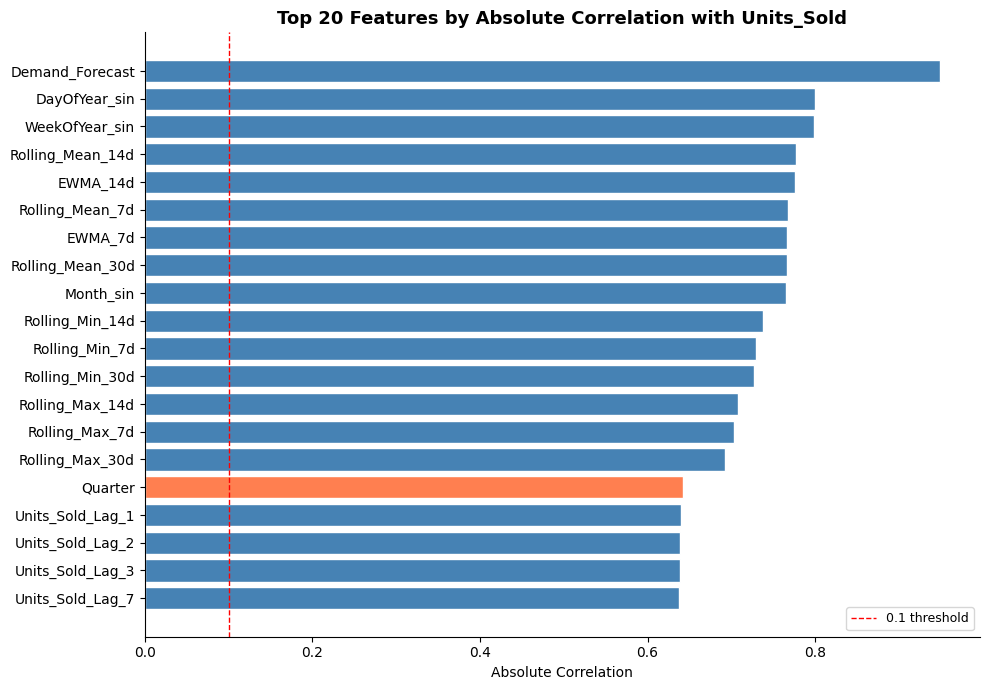


── Top 10 Correlated Features with Units_Sold ──
  Demand_Forecast                     : +0.9493
  DayOfYear_sin                       : +0.8001
  WeekOfYear_sin                      : +0.7981
  Rolling_Mean_14d                    : +0.7777
  EWMA_14d                            : +0.7763
  Rolling_Mean_7d                     : +0.7677
  EWMA_7d                             : +0.7669
  Rolling_Mean_30d                    : +0.7663
  Month_sin                           : +0.7655
  Rolling_Min_14d                     : +0.7374


In [14]:
# Quick feature correlation with target — top 20
feat_corr = df[XGBOOST_FEATURES + [TARGET]].corr()[TARGET].drop(TARGET)
feat_corr_abs = feat_corr.abs().sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 7))
colors = ['steelblue' if feat_corr[i] > 0 else 'coral' for i in feat_corr_abs.index]
ax.barh(feat_corr_abs.index[::-1], feat_corr_abs.values[::-1],
        color=colors[::-1], edgecolor='white')
ax.set_title('Top 20 Features by Absolute Correlation with Units_Sold', fontsize=13)
ax.set_xlabel('Absolute Correlation')
ax.axvline(0.1, color='red', linestyle='--', linewidth=1, label='0.1 threshold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print('\n── Top 10 Correlated Features with Units_Sold ──')
for feat in feat_corr_abs.head(10).index:
    direction = '+' if feat_corr[feat] > 0 else '-'
    print(f'  {feat:<35} : {direction}{feat_corr_abs[feat]:.4f}')

---
## 💾 Section 10: Save Outputs for LSTM & XGBoost

In [15]:
# ─────────────────────────────────────────────────────────────
# SECTION 10: SAVE OUTPUTS
# ─────────────────────────────────────────────────────────────

# ── Output 1: XGBoost flat feature matrix ──
# Keep Date, group keys + all features + target
xgb_save_cols = ['Date','SKU_ID','Warehouse_ID'] + XGBOOST_FEATURES + [TARGET]
xgb_save_cols = list(dict.fromkeys([c for c in xgb_save_cols if c in df.columns]))
df_xgb = df[xgb_save_cols].copy()
df_xgb.to_csv('features_xgboost.csv', index=False)
print(f'✅ XGBoost feature matrix saved: features_xgboost.csv')
print(f'   Shape: {df_xgb.shape}')
print()

# ── Output 2: LSTM sequential data ──
# For LSTM we keep the time-series columns: Date, group keys,
# the target, and a clean set of numeric features.
LSTM_FEATURES = [
    'Units_Sold',          # target (also used as input in sequence)
    'Inventory_Level',
    'Supplier_Lead_Time_Days',
    'Promotion_Flag',
    'Stockout_Flag',
    'Unit_Price',
    'Unit_Cost',
    'Demand_Forecast',
    'Rolling_Mean_7d',
    'Rolling_Mean_30d',
    'EWMA_7d',
    'Month_sin', 'Month_cos',
    'DayOfWeek_sin', 'DayOfWeek_cos',
    'Is_Weekend',
    'Demand_Momentum',
    'Stock_Gap',
    'Below_ROP_Flag',
    'SKU_ID_Enc',
    'Warehouse_ID_Enc'
]
LSTM_FEATURES = [f for f in LSTM_FEATURES if f in df.columns]

lstm_save_cols = ['Date', 'SKU_ID', 'Warehouse_ID'] + LSTM_FEATURES
lstm_save_cols = list(dict.fromkeys(lstm_save_cols))
df_lstm = df[lstm_save_cols].copy()
df_lstm.to_csv('features_lstm.csv', index=False)
print(f'✅ LSTM sequential data saved: features_lstm.csv')
print(f'   Shape: {df_lstm.shape}')
print(f'   LSTM input features: {len(LSTM_FEATURES)}')

# Save feature list for later reference
import json
feature_registry = {
    'target'           : TARGET,
    'xgboost_features' : XGBOOST_FEATURES,
    'lstm_features'    : LSTM_FEATURES,
    'group_keys'       : GROUP_KEYS
}
with open('feature_registry.json', 'w') as f:
    json.dump(feature_registry, f, indent=2)
print()
print('✅ Feature registry saved: feature_registry.json')
print('   ➡️  Proceed to Notebook 04: LSTM Model')

✅ XGBoost feature matrix saved: features_xgboost.csv
   Shape: (91250, 79)

✅ LSTM sequential data saved: features_lstm.csv
   Shape: (91250, 24)
   LSTM input features: 21

✅ Feature registry saved: feature_registry.json
   ➡️  Proceed to Notebook 04: LSTM Model


---
## ✅ Notebook 03 Summary

| Feature Group | Count | Purpose |
|---|---|---|
| Time Features | 19 | Calendar + cyclic encoding |
| Lag Features | 13 | Past demand signals |
| Rolling Window Features | 15 | Trend & volatility |
| Interaction Features | 11 | Cross-variable effects |
| Supplier/Inventory Features | 4 | Replenishment context |
| Encoded Categoricals | 4 | SKU, WH, Supplier, Region |
| **Total** | **~66** | **Full XGBoost feature set** |

**Outputs:**
- `features_xgboost.csv` — Full flat feature matrix for XGBoost
- `features_lstm.csv` — Lean sequential dataset for LSTM
- `feature_registry.json` — Saved feature lists for reproducibility

**➡️ Proceed to Notebook 04: LSTM Model**

---
*Intelligent Supply Chain Optimization System | Notebook 03 of 08*